In [1]:
import numpy as np
import scipy.fft as sfft
import matplotlib.pyplot as plt
%matplotlib inline

from devito import Grid, Function, TimeFunction, SparseTimeFunction, solve, Eq, Operator, Buffer
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource, Receiver, AcquisitionGeometry

Text(0.5,1,'|fft($u$)| at $t=0$')

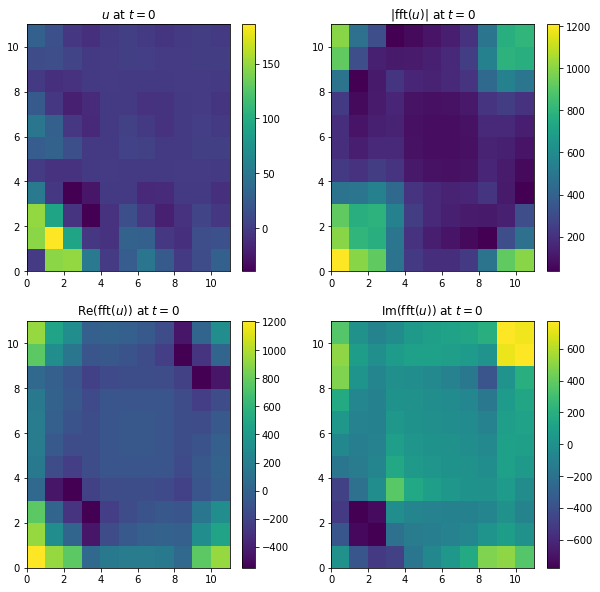

In [74]:
N = 15
def set_ic(u):
    for i in range(u.shape[0]):
        x = i / (u.shape[0]-1)
        for j in range(u.shape[1]):
            y = j / (u.shape[1]-1)
            for ii in range(1, N+1):
                for jj in range(1, N+1):
                    u[i, j] += np.sin(ii*x + jj*y)
    return u

size = (11, 11)
u = np.zeros(size)
u = set_ic(u)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_00 = axs[0, 0].pcolor(u.T)
axs[0, 0].set_title(r"$u$ at $t=0$")
cbar00 = fig.colorbar(plot_00, ax=axs[0, 0])

u_fft = sfft.fft2(u)
# print(u_fft)
# print(u_fft.shape, u_fft.dtype)
# print(np.min(np.imag(u_fft)), np.max(np.imag(u_fft)))
# print(np.min(np.real(u_fft)), np.max(np.real(u_fft)))
lvs = np.linspace(np.min(np.imag(u_fft)), np.max(np.imag(u_fft)), 100)
plot_01 = axs[1, 1].pcolor(np.imag(u_fft).T)
cbar01 = fig.colorbar(plot_01, ax=axs[1, 1])
axs[1, 1].set_title(r"Im(fft($u$)) at $t=0$")

plot_10 = axs[1, 0].pcolor(np.real(u_fft).T)
cbar10 = fig.colorbar(plot_10, ax=axs[1, 0])
axs[1, 0].set_title(r"Re(fft($u$)) at $t=0$")

u_recom = sfft.ifft2(u_fft)
plot_11 = axs[0, 1].pcolor(np.abs(u_fft).T)
cbar11 = fig.colorbar(plot_11, ax=axs[0, 1])
axs[0, 1].set_title(r"|fft($u$)| at $t=0$")

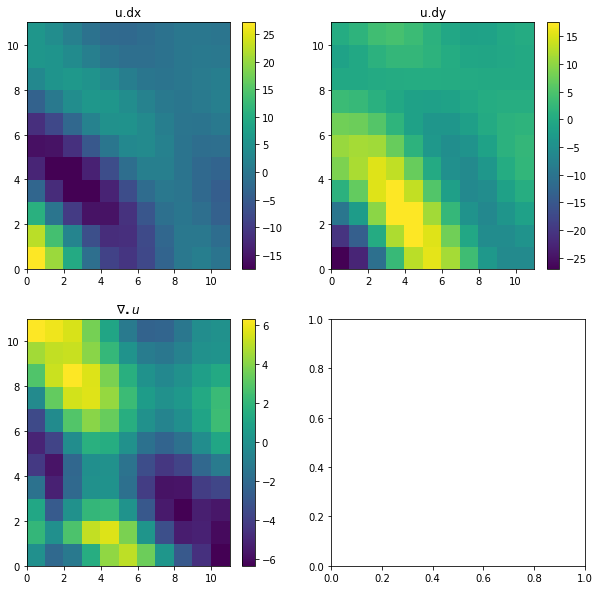

In [73]:
u_dx = np.zeros(u.shape)
u_dy = np.zeros(u.shape)
dx = dy = 1
for i in range(u.shape[0]):
    for j in range(u.shape[1]):
        if i == 0:                # Top row
            u_dy[i, j] = -(u[i+1, j] - u[i, j]) / dy
        elif i == u.shape[0] - 1: # Last row
            u_dy[i, j] = -(u[i, j] - u[i-1, j]) / dy
        else:
            u_dy[i, j] = -(u[i+1, j] - u[i-1, j]) / (2*dy)
        
        if j == 0:                # First column
            u_dx[i, j] = (u[i, j+1] - u[i, j]) / dx
        elif j == u.shape[1] - 1: # Last column
            u_dx[i, j] = (u[i, j] - u[i, j-1]) / dx
        else:
            u_dx[i, j] = (u[i, j+1] - u[i, j-1]) / (2*dx)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_00 = axs[0, 0].pcolor(u_dx.T)
axs[0, 0].set_title("u.dx")
_ = fig.colorbar(plot_00, ax=axs[0, 0])

plot_01 = axs[0, 1].pcolor(u_dy.T)
axs[0, 1].set_title("u.dy")
_ = fig.colorbar(plot_01, ax=axs[0, 1])

plot_10 = axs[1, 0].pcolor((u_dx + u_dy).T)
axs[1, 0].set_title(r"$\nabla \mathbf{.} u$")
_ = fig.colorbar(plot_10, ax=axs[1, 0])

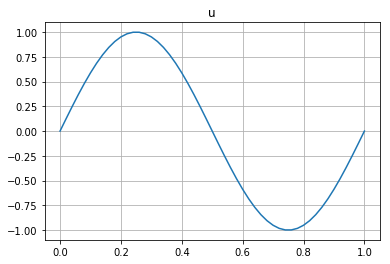

In [110]:
N = 1
def set_ic(u):
    for i in range(u.shape[0]):
        x = (i / (u.shape[0]-1))
        for k in range(1, N+1):
            u[i] += np.sin(2 * np.pi * k * x)
    
    return u
u = np.zeros(51)
u = set_ic(u)
plt.plot(np.linspace(0, 1, num=u.shape[0]), sfft.ifft(sfft.fft(u)), label='u')
plt.title('u')
plt.grid()

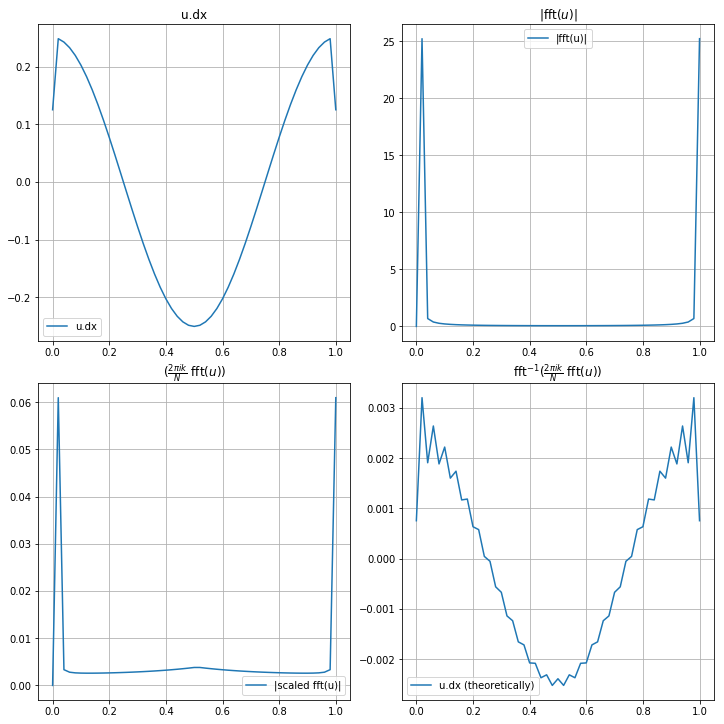

In [122]:
u_dx = np.zeros(u.shape)
dx = 1
for i in range(u.shape[0]):
    if i == 0:
        u_dx[i] = (u[i+1] - u[i]) / dx
    elif i == u.shape[0]-1:
        u_dx[i] = (u[i] - u[i-1]) / dx
    else:
        u_dx[i] = (u[i+1] - u[i-1]) / dx

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# plots = []
# row = []
# axs_i, axs_j = 0, 0
# _ = axs[axs_i, axs_j].plot(np.linspace(0, 1, num=u.shape[0]), u, label='u')
# axs[axs_i, axs_j].set_title(r"$u$")
# axs[axs_i, axs_j].legend()
# axs[axs_i, axs_j].grid()

axs_i, axs_j = 0, 1
u_fft = sfft.fft(u)
_ = (axs[axs_i, axs_j].plot(np.linspace(0, 1, num=u.shape[0]), np.abs(u_fft), label='|fft(u)|'))
axs[axs_i, axs_j].set_title(r"|fft($u$)|")
axs[axs_i, axs_j].legend()
axs[axs_i, axs_j].grid()
# plots.append(row)
# print(u_fft)
# row2 = []

axs_i, axs_j = 0, 0
_ = (axs[axs_i, axs_j].plot(np.linspace(0, 1, num=u.shape[0]), u_dx, label='u.dx'))
axs[axs_i, axs_j].set_title(r"u.dx")
axs[axs_i, axs_j].legend()
axs[axs_i, axs_j].grid()

# Do scaling
axs_i, axs_j = 1, 0
scaled_ufft = np.array(u_fft)
N = u_fft.shape[0]
f = sfft.fftfreq(u.shape[0])
for k in range(scaled_ufft.shape[0]):
    scaled_ufft[k] = ((2j * f[k] * np.pi / N)) * u_fft[k]

_ = axs[axs_i, axs_j].plot(np.linspace(0, 1, num=u.shape[0]), np.abs(scaled_ufft), label='|scaled fft(u)|')
axs[axs_i, axs_j].set_title(r"$(\frac{2\pi i k}{N}$ fft($u))$")
axs[axs_i, axs_j].legend()
axs[axs_i, axs_j].grid()

axs_i, axs_j = 1, 1
u_dx_recombined = sfft.ifft(scaled_ufft)

# print(u_dx_recombined / 10)
_ = axs[axs_i, axs_j].plot(np.linspace(0, 1, num=u.shape[0]), u_dx_recombined, label='u.dx (theoretically)')
axs[axs_i, axs_j].set_title(r"fft$^{-1}(\frac{2\pi i k}{N}$ fft($u))$")
axs[axs_i, axs_j].legend()
axs[axs_i, axs_j].grid()

fig.tight_layout(pad=0.5)
# plots.append(row2)

In [117]:
print(u_dx_recombined)
print(scaled_ufft)

[ 1.84601789e-15+27.34658809j  3.93745966e+00+28.16706272j
  7.81282323e+00+27.91507169j  1.15649739e+01+27.01236166j
  1.51347380e+01+25.57760596j  1.84658183e+01+23.67519947j
  2.15056816e+01+21.35602075j  2.42063874e+01+18.66856603j
  2.65253441e+01+15.66266051j  2.84259802e+01+12.39066182j
  2.98783216e+01 +8.9076289j   3.08594641e+01 +5.270996j
  3.13539344e+01 +1.53998323j  3.13539344e+01 -2.22514288j
  3.08594641e+01 -5.96389494j  2.98783216e+01 -9.61643551j
  2.84259802e+01-13.12446378j  2.65253441e+01-16.43209499j
  2.42063874e+01-19.48671305j  2.15056816e+01-22.23977946j
  1.84658183e+01-24.64758336j  1.51347380e+01-26.67191942j
  1.15649739e+01-28.28068194j  7.81282323e+00-29.44836495j
  3.93745966e+00-30.15645999j  2.22915368e-15-30.39374509j
 -3.93745966e+00-30.15645999j -7.81282323e+00-29.44836495j
 -1.15649739e+01-28.28068194j -1.51347380e+01-26.67191942j
 -1.84658183e+01-24.64758336j -2.15056816e+01-22.23977946j
 -2.42063874e+01-19.48671305j -2.65253441e+01-16.43209499j